## Max dwelling in between

1. disambiguous and resolve conflicts [see Disambiguous_Analysis_ notebook for more detail]
2. Set the max number of dwellings between two known dwellings for sequence interpolation

In [48]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import disambiguation_analysis as da

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Data

In [49]:
## to save data later
census_filled_file = "../../data/dwelling_filled_sum_1850_mn_v01.csv"

In [50]:
census = pd.read_csv("../../data/census_1850_indexUpdate.csv")
disambiguation = pd.read_csv("../../data/1850_disambiguated.csv")
city_directory = pd.read_csv("../../data/cd_1850_XYupdate.csv")

In [51]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "BLOCK_NUM"
cd_ward_col = "Ward_Num"
cd_block_col = "block_num"
dwelling_num_col = "CENSUS_DWELLING_NUM"

### Initial disambiguation analysis

In [52]:
census_disamb = da.add_disamb_census(disambiguation, census)

In [53]:
#create unique dwelling id
census_disamb = census_disamb.groupby(ward_col, as_index = False).apply(lambda x: dataprocessing.create_unique_dwelling(x, dwelling_num_col))

In [54]:
total_num_dwellings = census_disamb.groupby([ward_col, dwelling_col]).ngroups

In [55]:
#Resolve dwelling conflicts
census_filled = census_disamb.groupby([ward_col, dwelling_col]).apply(lambda x: da.dwelling_weight_fill(x, block_col = block_col))
#Add in values dropped because they don't have a dwelling number
census_filled = pd.concat([census_filled, census_disamb[census_disamb[dwelling_col].isnull()]], sort= True)
census_filled.reset_index(drop = True, inplace = True)
# census_filled.to_csv(census_filled_file, index = False)

In [56]:
census_filled_dwellings = census_filled.groupby([ward_col, dwelling_col], as_index = False).first()

### keep only known dwellings and apply sequences

In [57]:
dwellings_dropped = census_filled_dwellings.dropna(subset = [block_col])
dwellings_dropped = dwellings_dropped.groupby(ward_col, as_index = False).apply(sequences.col_for_seq)

In [58]:
#Select maximum possible distance between consecutive known addresses
#Based on two options, number of 
options = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
minimize_lengths = [1]
sequence_tuning = sequences.tune_sequence_dist(dwellings_dropped, options, minimize_lengths)
print("Selected maximum distance between consecutive dwellings:", sequence_tuning["dist"])
dwellings_sequence = sequence_tuning["df"]

d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d

### Interpolation Between Known Addresses

**Problem:** Intuitively, if, during the disambiguation process consecutive known dwellings have the same block number or street name, it seems possible that the dwellings in between those known addresses would share that block number/street name. How accurate is making that assumption and simply filling in those unknown block numbers/street names? And how many dwellings can we gather more information for that way? How many dwellings should we limit this process to. For example, if there are 100 dwellings in between known address the validity of simply filling in the block number feels weaker than if there were only 2 dwellings in between.\
**Method:** Get known consecutive dwellings with shared block numbers/street name and dwellings with unknown addresses in between. Experiment with different limits of number of dwellings in between

## Interpolate sequences if number of dwellings between known dwellings do not exceed threshold

In [84]:
## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
## dwellings_sequence => known dwellings with sequence_id
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                                      'BLOCK_NUM_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

"""
3. Merge `dwellings_sequence_with_next_info` back to df of all dwellings. Ffill sequences between 
2 known dwellings of the same sequences.
"""
all_dwellings = dataprocessing.all_dwellings_sequenced(census_filled_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = 'BLOCK_NUM', fill_column = 'sequence_id',
                                                       check_column = 'BLOCK_NUM', ward_col = ward_col, dwelling_col = dwelling_col)

"""
4. Get consecutive dwellings that are in between 2 known dwellngs of the same sequence and block_col value.
Used for plotting.
"""
interpolate_dwellings = interpolation.get_consecutive_dwellings(all_dwellings, column = block_col)

### all_dwellings contains all dwellings with interpolation on fill_column = 'sequence_id'

## Max dwellning analysis

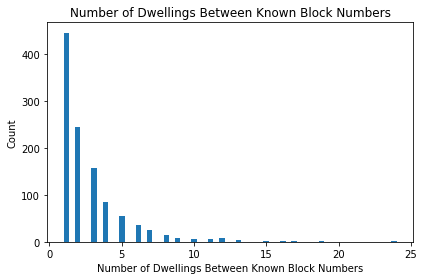

In [66]:
plt.hist(interpolate_dwellings.dropna(subset=['num_between_real'])["num_between_real"], bins = "auto")
plt.xlabel("Number of Dwellings Between Known Block Numbers")
plt.ylabel("Count")
plt.title("Number of Dwellings Between Known Block Numbers")
plt.tight_layout()
plt.show()

In [85]:
"""
3. Merge `dwellings_sequence_with_next_info` back to df of all dwellings. Ffill sequences between 
2 known dwellings of the same sequences.
"""
all_dwellings_seq = dataprocessing.all_dwellings_sequenced(census_filled_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = 'BLOCK_NUM', fill_column = 'sequence_id',
                                                       check_column = 'sequence_id', ward_col = ward_col, dwelling_col = dwelling_col)


In [92]:
## The number of differences interpolation bewteen only block num vs blocknum + sequence id
(all_dwellings_seq[['sequence_id']].replace(np.nan, -1) != all_dwellings[['sequence_id']].replace(np.nan, -1)).sum()

sequence_id    0
dtype: int64

### Using only block number

Same output as using distance sequence as well

In [68]:
num_between = [5,10,15, 20, 25,40]
inter
for num in num_between:
    to_interpolate = interpolation.limit_dwellings_between(interpolate_dwellings,num)
    total_interpolate = to_interpolate["CD_ADDRESS"].isnull().sum()
    print("Maximum of {} dwellings between".format(str(num)))
#     display(to_interpolate.loc[:,[ward_col, dwelling_col, block_col, "CD_ADDRESS", "CD_X", "CD_Y", "sequence_id"]].head(10))
    print("Number of dwellings that would be assigned a block:", total_interpolate)
    print("Proportion increase dwellings assigned a block:", round(total_interpolate/total_num_dwellings, 5), "\n")

Maximum of 5 dwellings between
Number of dwellings that would be assigned a block: 2015
Proportion increase dwellings assigned a block: 0.05226 

Maximum of 10 dwellings between
Number of dwellings that would be assigned a block: 2653
Proportion increase dwellings assigned a block: 0.0688 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 2895
Proportion increase dwellings assigned a block: 0.07508 

Maximum of 20 dwellings between
Number of dwellings that would be assigned a block: 2947
Proportion increase dwellings assigned a block: 0.07643 

Maximum of 25 dwellings between
Number of dwellings that would be assigned a block: 2971
Proportion increase dwellings assigned a block: 0.07705 

Maximum of 40 dwellings between
Number of dwellings that would be assigned a block: 2971
Proportion increase dwellings assigned a block: 0.07705 



* There are mostly below 10 unknoqn dwellings between 2 known dwellings in the same block number
* The proportion increase dwellings assigned does not change much after max dwelling = 20
* max dwelling = 10 is intuitively accurate. Is there any insight to support this?